# **House Prices - Advanced Regression Techniques**

<h3 data-start="217" data-end="248">Sobre M&iacute;</h3>
<p data-start="249" data-end="620">Como Data Science junior, busco aplicar mis conocimientos en an&aacute;lisis exploratorio, visualizaci&oacute;n y modelos predictivos para aportar valor en la toma de decisiones basada en datos. Me interesa crecer en entornos colaborativos donde pueda aprender de proyectos reales, desarrollar soluciones con impacto y continuar form&aacute;ndome en ciencia de datos aplicada al negocio. Tengo experiencia pr&aacute;ctica en limpieza de datos, visualizaci&oacute;n con herramientas como Matplotlib y Seaborn, y creaci&oacute;n de modelos b&aacute;sicos con scikit-learn y redes neuronales en Keras.&nbsp;</p>
<h6 style="text-align: right;" data-start="249" data-end="620">Romero Olmos, Luis Eduardo<br />Correo: <a href="mailto:luiseduardoromeroolmos@aol.com">luiseduardoromeroolmos@aol.com</a><br />Git: https://github.com/LuisEduardoRomeroOlmos<br />Kaggle: https://www.kaggle.com/luiseduardoromeroolm</h6>

**Goal:**  It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable.

### **Librerías Necesarias para ejecutar el código.**

In [ ]:
!pip uninstall -y torch torchvision torchaudio pytorch-lightning torchmetrics transformers pytorch-tabular

In [ ]:
!pip install torch==2.1.2+cpu torchvision==0.16.2+cpu torchaudio==2.1.2 --index-url https://download.pytorch.org/whl/cpu

In [ ]:
!pip install torchmetrics==1.2.1 pytorch-tabular==1.1.0 pytorch-lightning==2.1.3 transformers==4.38.2

### **Imports**

In [341]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [342]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from pytorch_tabular.models import TabTransformerModel, TabTransformerConfig
from pytorch_tabular.models import TabTransformerModel
from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, TrainerConfig, OptimizerConfig, ModelConfig
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

## **1. Lectura del conjunto de datos**

In [343]:
# Carga del Dataset
df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

## 2. **Visualización del conjunto de datos**

In [344]:
#Visualizacion de los datos de entrenamiento
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [345]:
# Comprobamos si alguna columna tiene valores nulos
df.isna().sum()[df.isna().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

## **3. Preparación del conjunto de datos¶**


In [346]:
# Eliminar columnas con muchos nulos Threshold del 46%
threshold = 0.46
cols_to_drop = df.isnull().mean()[lambda x: x > threshold].index
df.drop(columns=cols_to_drop, inplace=True)

In [347]:
#Esta columna no aporta nada, la eliminamos
df.drop(columns=["Id"], inplace=True)

In [348]:
#Verificamos si fueron eliminadas las columnas correctamente.
df.isna().sum()[df.isna().sum() > 0]

LotFrontage     259
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

In [349]:
#Separacion de X y Y Para el preprocesamiento
y = df['SalePrice']
X = df.drop(["SalePrice"], axis=1)

In [350]:
#Separacion del Train y Val para no caer en Data leakage
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42 )

In [351]:
# Obtener las columnas numéricas y categóricas usadas (Esto es para el transformer)
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include='object').columns

In [352]:
# Pipelines de preprocesamiento - Se sustituye en las columnas numericas  por la mediana
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Se imputan variables categoricas con la moda y se convierten a columnas categoricas a numericas
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])
# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=['int64', 'float64'])),
    ('cat', cat_pipeline, make_column_selector(dtype_include='object'))
])

In [353]:
#Aplicamos el Preprocesamiento y añadimos de nuevo las columnas. Se necesitan datos tabulares.

# Aplicar transformador
X_train_pre = preprocessor.fit_transform(X_train)
X_val_pre = preprocessor.transform(X_val)

# Crear un nuevo DataFrame con las columnas
X_train_df = pd.DataFrame(X_train_pre, columns=list(num_cols) + list(cat_cols))
X_val_df = pd.DataFrame(X_val_pre, columns=list(num_cols) + list(cat_cols))

# Reconocer qué columnas deben ser numéricas
X_train_df[num_cols] = X_train_df[num_cols].apply(pd.to_numeric)
X_val_df[num_cols] = X_val_df[num_cols].apply(pd.to_numeric)

# Las categóricas (si no se codificaron con one-hot) pueden convertirse a string o categoría
X_train_df[cat_cols] = X_train_df[cat_cols].astype("object")
X_val_df[cat_cols] = X_val_df[cat_cols].astype("object")

In [354]:
#Escalamos tambien el target, el transformer da malos resultados si no se normaliza

scaler = RobustScaler()

# Asegura que sean 2D
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler.transform(y_val.values.reshape(-1, 1))

# Si quieres convertirlos de nuevo a Series
y_train = pd.Series(y_train_scaled.ravel(), index=y_train.index)
y_val = pd.Series(y_val_scaled.ravel(), index=y_val.index)

In [355]:
#Comprobamos que este todo correcto
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   float64
 1   LotFrontage    1168 non-null   float64
 2   LotArea        1168 non-null   float64
 3   OverallQual    1168 non-null   float64
 4   OverallCond    1168 non-null   float64
 5   YearBuilt      1168 non-null   float64
 6   YearRemodAdd   1168 non-null   float64
 7   MasVnrArea     1168 non-null   float64
 8   BsmtFinSF1     1168 non-null   float64
 9   BsmtFinSF2     1168 non-null   float64
 10  BsmtUnfSF      1168 non-null   float64
 11  TotalBsmtSF    1168 non-null   float64
 12  1stFlrSF       1168 non-null   float64
 13  2ndFlrSF       1168 non-null   float64
 14  LowQualFinSF   1168 non-null   float64
 15  GrLivArea      1168 non-null   float64
 16  BsmtFullBath   1168 non-null   float64
 17  BsmtHalfBath   1168 non-null   float64
 18  FullBath

In [356]:
# Reseteamos el index para no tener datos desfazados.
X_train_df.reset_index(drop=True, inplace=True)
X_val_df.reset_index(drop=True, inplace=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [357]:
# Unimos X y Y que son los datos que espera el modelo.
train_df = X_train_df.copy()
train_df["SalePrice"] = y_train

val_df = X_val_df.copy()
val_df["SalePrice"] = y_val

In [358]:
#Comprobamos que no este desfazado
nulos = train_df.isnull().sum()
print(nulos[nulos > 0])

Series([], dtype: int64)


In [359]:
#Comprobamos que los datos estan correctos
train_df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,-0.6,0.000000,-0.291776,-0.5,1.0,-0.312500,-0.973684,0.000000,0.745492,0.0,...,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,-0.235502
1,0.2,-0.578947,-0.428667,0.0,2.0,0.437500,0.000000,0.000000,-0.533287,0.0,...,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,0.153076
2,-0.4,-0.157895,-0.200109,-0.5,2.0,-1.291667,-1.157895,0.000000,-0.533287,0.0,...,TA,Typ,Attchd,Unf,TA,TA,P,WD,Normal,-0.942008
3,0.0,-0.526316,-0.583551,-0.5,2.0,-0.729167,-1.157895,1.518072,0.255895,0.0,...,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Normal,0.117751
4,0.0,-1.052632,-1.118473,-0.5,1.0,-1.000000,-1.157895,0.000000,-0.230929,0.0,...,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Normal,-0.447454


## **4.- El Modelo: TabTransformerModel**

In [360]:
#Definimos las metricas del modelo

#Definimos que guarde el mejor modelo
model_checkpoint = ModelCheckpoint(
    monitor="valid_r2_score", mode="max", save_top_k=1, filename="best-checkpoint"
)
#Definimos  que datos son categoricos y continuos
data_config = DataConfig(
    target=["SalePrice"],
    continuous_cols=list(num_cols),
    categorical_cols=list(cat_cols),   
)
#Definimos el modelo, el learning rate...
model_config = TabTransformerConfig(
    task="regression",
    learning_rate=1e-3,
    metrics=["r2_score", "mean_absolute_error"],
    seed=42,
)
#Configuramos el entrenamiento
trainer_config = TrainerConfig(
    max_epochs=100, 
    batch_size=256, 
    early_stopping_patience=70,
  
)
# Armamos el Modelo.
tabular_model = TabularModel(
    data_config=data_config,
     model_config=model_config,
    trainer_config=trainer_config,
    optimizer_config=OptimizerConfig(),
    model_callable=TabTransformerModel,
)

In [361]:
#Ignoramos los Warnings para que no se llene la pantalla.

import warnings

# Filtrar solo los FutureWarning de pandas 
warnings.simplefilter(action='ignore', category=FutureWarning)

# Ignorar SettingWithCopyWarning si aparece
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

### **4.1.-Entrenamos al modelo**

In [362]:
#Entrenamos el modelo
tabular_model.fit(train=train_df, validation=val_df,callbacks=[model_checkpoint],)

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /kaggle/working/saved_models exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  271 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │  8.8 K │
│ 2 │ _head            │ LinearHead             │  1.2 K │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 281 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 281 K                                                                                                
Total estimated model params size (MB): 1

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (5)
is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you 
want to see logs for the training epoch.

### **4.2.- Evaluación del Modelo**

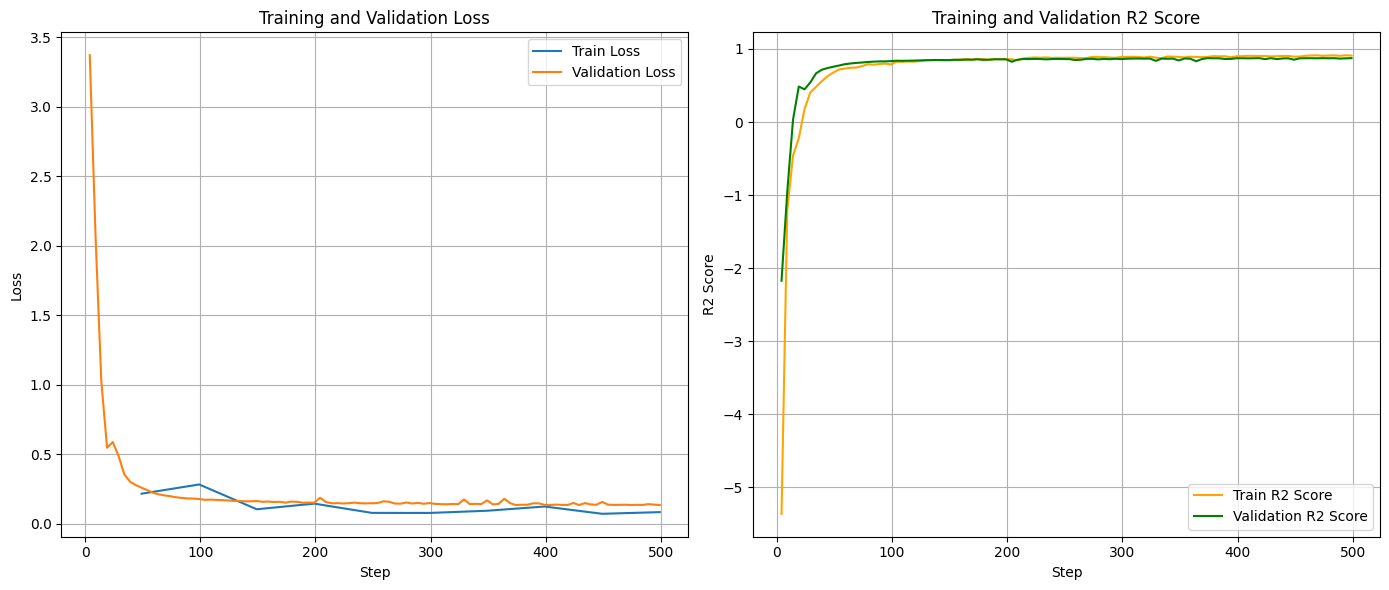

In [364]:
#Evaluamos el modelo mediante la evolucion del Loss y el R2 proporcionados por TensorBoard
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

log_dir = "./lightning_logs/version_23"
ea = event_accumulator.EventAccumulator(log_dir)
ea.Reload()

def get_steps_and_values(tag):
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    return steps, values

steps_train_loss, train_loss = get_steps_and_values("train_loss")
steps_valid_loss, valid_loss = get_steps_and_values("valid_loss")

steps_train_r2, train_r2 = get_steps_and_values("train_r2_score")
steps_valid_r2, valid_r2 = get_steps_and_values("valid_r2_score")

# Graficar pérdidas
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.plot(steps_train_loss, train_loss, label="Train Loss")
plt.plot(steps_valid_loss, valid_loss, label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# Graficar R2 (no asumas que las longitudes son iguales, grafica según sus pasos)
plt.subplot(1,2,2)
plt.plot(steps_train_r2, train_r2, label="Train R2 Score", color='orange')
plt.plot(steps_valid_r2, valid_r2, label="Validation R2 Score", color='green')
plt.xlabel("Step")
plt.ylabel("R2 Score")
plt.title("Training and Validation R2 Score")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [365]:
# Evaluación final manual
results = tabular_model.evaluate(val_df)
print("Resultados finales:", results)

Output()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.13366957008838654    │
│ test_mean_absolute_error  │    0.2349444329738617     │
│       test_r2_score       │    0.8739911913871765     │
└───────────────────────────┴───────────────────────────┘

Resultados finales: [{'test_loss': 0.13366957008838654, 'test_r2_score': 0.8739911913871765, 'test_mean_absolute_error': 0.2349444329738617}]


In [256]:
#Guardamos el Modelo con mejores resultados.
tabular_model.save_model("modelo_tabular V2:877%")

## 5.-Predicción del modelo con el conjunto de Prueba

In [366]:
#Cargamos el conjunto de prueba
df_prueba = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [367]:
#Creamos una copia
df_test = df_prueba.copy()

In [368]:
#Eliminamos las columnas del principio + Id que no nos funciona.
df_test = df_test.drop(columns=list(cols_to_drop) + ["Id"])

In [369]:
#Buscamos Valores Nulos
print(df_test.isnull().sum().sum())  

869


In [370]:
#Aplicamos el procesamiento que creamos anteriormente .transform

# Aplicar transformador
df_limpio = preprocessor.transform(df_test)
# Crear un nuevo DataFrame con las columnas
df_trans = pd.DataFrame(df_limpio, columns=list(num_cols) + list(cat_cols))
# Reconocer qué columnas deben ser numéricas
df_trans[num_cols] = df_trans[num_cols].apply(pd.to_numeric)
# Las categóricas (si no se codificaron con one-hot) pueden convertirse a string o categoría
df_trans[cat_cols] = df_trans[cat_cols].astype("object")

In [371]:
#Visualizamos los valores a predecir
df_trans

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,-0.6,0.526316,0.491642,-0.5,1.0,-0.229167,-0.868421,0.000000,0.115811,144.0,...,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
1,-0.6,0.578947,1.134764,0.0,1.0,-0.291667,-0.947368,0.650602,0.746879,0.0,...,SBrkr,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
2,0.2,0.210526,1.028509,-0.5,0.0,0.520833,0.105263,0.000000,0.563800,0.0,...,SBrkr,TA,Typ,Attchd,Fin,TA,TA,Y,WD,Normal
3,0.2,0.421053,0.091909,0.0,1.0,0.541667,0.105263,0.120482,0.301664,0.0,...,SBrkr,Gd,Typ,Attchd,Fin,TA,TA,Y,WD,Normal
4,1.4,-1.421053,-1.117257,1.0,0.0,0.416667,-0.052632,0.000000,-0.168516,0.0,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.2,-2.578947,-1.863473,-1.0,2.0,-0.041667,-0.631579,0.000000,-0.533287,0.0,...,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
1455,2.2,-2.578947,-1.873685,-1.0,0.0,-0.041667,-0.631579,0.000000,-0.183773,0.0,...,SBrkr,TA,Typ,CarPort,Unf,TA,TA,Y,WD,Abnorml
1456,-0.6,4.736842,2.528722,-0.5,2.0,-0.250000,0.052632,0.000000,1.164355,0.0,...,SBrkr,TA,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
1457,0.7,-0.421053,0.204486,-0.5,0.0,0.416667,-0.052632,0.000000,-0.065881,0.0,...,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal


In [372]:
# Predecimos con los datos tabulares
preds = tabular_model.predict(df_trans)

In [373]:
#Aplicamos la transformacion inversa de la normalizacion
predictions = scaler.inverse_transform(preds.values.reshape(-1, 1)).flatten()
print(predictions)

[116739.664 146009.25  176052.84  ... 174181.77   96221.15  213265.31 ]


In [374]:
# Crear el DataFrame para el submission, como lo pide Kaggle
submission = pd.DataFrame({
    "Id": df_prueba["Id"],
    "SalePrice": predictions
})
# Guardar a CSV
submission.to_csv("submission.csv", index=False)

In [376]:
#Checamos que se haya creado correctamenet
submission.head()

,Id,SalePrice
0,1461,116739.664062
1,1462,146009.250000
2,1463,176052.843750
3,1464,195341.171875
4,1465,208826.359375


**Conclusión:**

En mi afán por seguir practicando y explorando nuevas herramientas, decidí probar enfoques distintos en busca de mejorar los resultados. Si bien obtener un 87% de R² es bastante bueno, no logré superar el 90% alcanzado con XGBoost optimizado, aunque sí logré superar el 85% obtenido con una red MLP.

Una realidad que descubrí es que el uso de modelos como TabTransformer implica una carga considerable de preprocesamiento y una mayor complejidad para mantener la armonía entre las distintas librerías, en comparación con modelos más establecidos como XGBoost o MLP. Además, el tamaño limitado del dataset representó un reto importante y a la vez. No obstante, incluso ajustando el número de épocas, el learning rate y el tamaño del batch, el modelo converge consistentemente con un R² entre 87% y 88%. Esto puede comprobarse visualmente en las gráficas presentadas más arriba, donde se observa claramente un techo de rendimiento.

A pesar de no haber mejorado los resultados, el proceso fue valioso: aprendí mucho sobre arquitectura de Transformers aplicados a datos tabulares, manejo de configuración en PyTorch Tabular, y buenas prácticas en experimentación. La experiencia sin duda suma al camino.

In [377]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
